<div style="text-align: center;">
  <img src="https://github.com/Hack-io-Data/Imagenes/blob/main/01-LogosHackio/logo_naranja@4x.png?raw=true" alt="esquema" />
</div>


# Laboratorio de Gestión de Outliers

AutoRenew, la empresa líder en la venta de coches de segunda mano, sigue adelante con el desarrollo del modelo predictivo que ayudará a estimar el precio de los vehículos usados. Este modelo es clave para mejorar las estrategias de ventas, marketing y optimización del inventario de la empresa. Ya has realizado un análisis exploratorio inicial y gestionado los valores nulos en el conjunto de datos. Ahora, es el momento de abordar otro aspecto crucial del preprocesamiento: la **gestión de outliers**.

En este laboratorio, te enfocarás en identificar y gestionar los outliers (valores atípicos) presentes en el conjunto de datos. Los outliers pueden distorsionar los resultados de un análisis y afectar negativamente el rendimiento de los modelos predictivos, por lo que es fundamental tratarlos adecuadamente antes de proceder con las siguientes fases del proyecto.


**Instrucciones:**

1. **Identificación de Outliers:** Explora las columnas clave del conjunto de datos (como `price`, `powerCV`, `kilometer`, etc.) para identificar posibles outliers. Utiliza gráficos como diagramas de caja (boxplots) y análisis estadísticos para detectar valores que se desvíen significativamente del resto de los datos.

2. **Análisis de Outliers:** Una vez identificados, analiza los outliers para determinar si son errores de datos, valores extremos válidos o resultados de condiciones específicas que deben ser tenidos en cuenta. Considera el contexto de cada columna al evaluar la relevancia de estos valores atípicos.

3. **Gestión de Outliers:** Decide la estrategia más adecuada para manejar los outliers. Esto podría incluir la eliminación de los outliers, la transformación de los datos, o la aplicación de técnicas de imputación. Justifica tu elección basándote en cómo los outliers podrían afectar el modelo predictivo.

**Nota:** Recuerda que este laboratorio es parte de una serie de actividades en las que utilizarás el mismo conjunto de datos a lo largo de la semana. Documenta cuidadosamente los pasos que sigas para que puedas referirte a ellos en las próximas etapas del proyecto.


In [26]:
# Tratamiento de datos
# -----------------------------------------------------------------------
import numpy as np
import pandas as pd

# Otros objetivos
# -----------------------------------------------------------------------
import math

# Gráficos
# -----------------------------------------------------------------------
import seaborn as sns
import matplotlib.pyplot as plt
import plotly_express as px


# Métodos estadísticos
# -----------------------------------------------------------------------
from scipy.stats import zscore # para calcular el z-score
from sklearn.neighbors import LocalOutlierFactor # para detectar outliers usando el método LOF
from sklearn.ensemble import IsolationForest # para detectar outliers usando el metodo IF
from sklearn.neighbors import NearestNeighbors # para calcular la epsilon
from sklearn.impute import KNNImputer
# Para generar combinaciones de listas
# -----------------------------------------------------------------------
from itertools import product , combinations
from sklearn.experimental import enable_iterative_imputer  # Necesario para habilitar IterativeImputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor

# Gestionar warnings
# -----------------------------------------------------------------------
import warnings
warnings.filterwarnings('ignore')
import sys
sys.path.append("../../")
from src.SupportOutliers import (
    plot_outliers_univariados,
    identificar_outliers_iqr,
    identificar_outliers_z,
    visualizar_outliers_bivariados,
    explorar_outliers_if,
    explorar_outliers_lof
)

In [2]:
df = pd.read_csv("../../datos/02_Modelo2/03_autorenew_feature_scaling.csv",index_col=0)
df.head()

,seller,offerType,brand,vehicleType,fuelType,gearbox,notRepairedDamage,kilometer,powerCV,price,yearOfRegistration,price_robust_scaler,powerCV_robust_scaler
0,private,offer,volkswagen,other,petrol,manually,unknown,150000,81.700794,480.0,The 90's,-0.430645,-0.441924
1,private,offer,audi,coupe,diesel,manually,yes,125000,187.000000,18300.0,The 2010,2.443548,1.146318
2,private,offer,jeep,suv,diesel,automatic,unknown,125000,161.000000,9800.0,The 2000,1.072581,0.754157
3,private,offer,volkswagen,small car,petrol,manually,no,150000,74.000000,1500.0,The 2000,-0.266129,-0.558076
4,private,offer,skoda,small car,diesel,manually,no,90000,68.000000,3600.0,The 2000,0.072581,-0.648575


# Eliminar Duplicados

Debería haberlo hecho antes, pero lo hacemos ahora

In [3]:
df.drop_duplicates(inplace=True)
df.reset_index(inplace=True,drop=True)

# 1 Identificación de Outliers
En nuestro caso contamos con dos categorías numéricas: **price** y **powerCV**, la variable precio es nuestra variable respuesta por lo que no podemos gestionar los outliers, podremos eliminarlos o dejarlos más adelante pero no nulificarlos no reemplazarlos por la media, pero si podemos usarla para observar los outliers univariados y multivariados.

Vamos a realizar unas gráficas, boxplot e histplot con intención de ver que ocurre como elementos univariados

### Nota
Vamos a usar las columnas **price_robust_scaler** y **powerCV_robust_scaler** que las hemos hecho para algo!, además es con las que hay que hacerlas, de ahora en adelante usamos estas, no vamos a borrar price y CV originales por tenerlas de referencia 

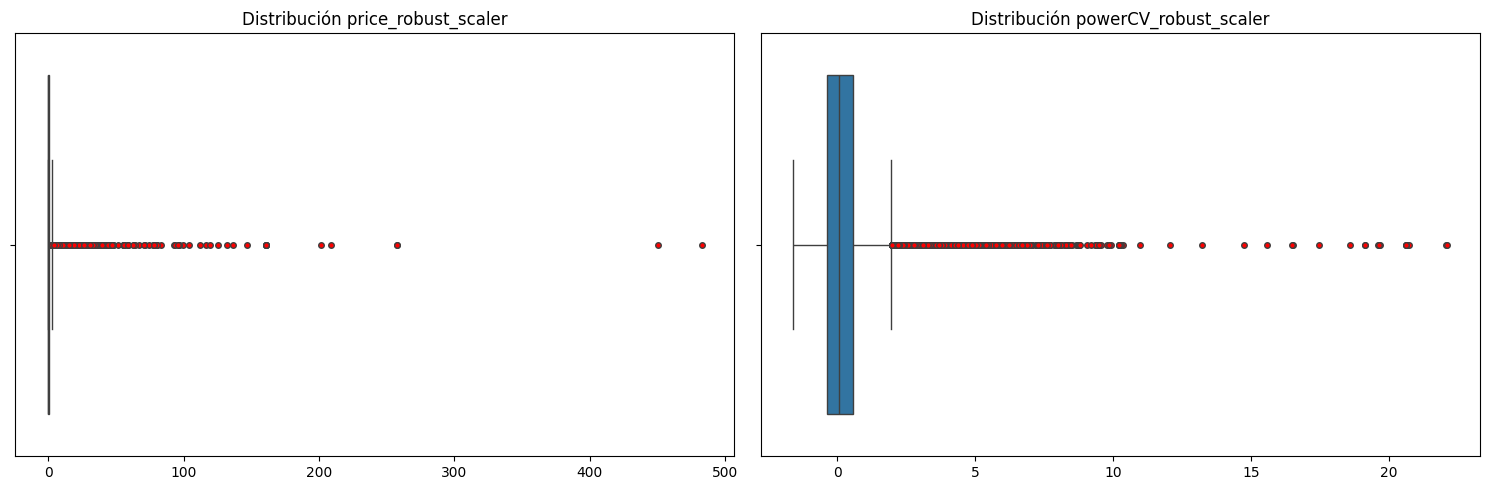

In [4]:
df_num = df[["price_robust_scaler","powerCV_robust_scaler"]]
plot_outliers_univariados(df_num,"b",20,(15,5))

# Sobre las Gráficas
- Como ya sabíamos tenemos bastantes valores outliers en ambas gráficas, sobre todo en price, veamos el histplot

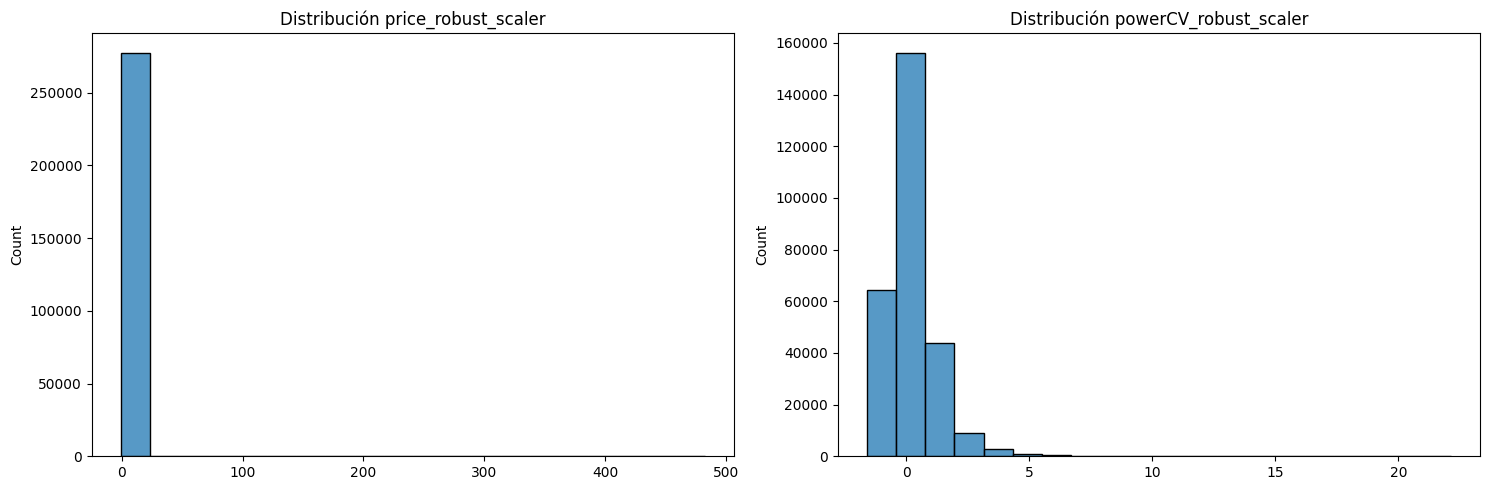

In [5]:
df_num = df[["price_robust_scaler","powerCV_robust_scaler"]]
plot_outliers_univariados(df_num,"h",20,(15,5))

# Sobre las Gráficas
- No son datos normales.
- Tienen bastantes outliers

# Conclusiones
 
Viendo los datos que tenemos y que no son normales, esto nos lleva a tener que usar el método IQR! para el analisis de Outliers

# Identificar Multivariadas
Necesitamos dos variables o más para poder observarlos, ya que algunos outliers no aparecen hasta que las juntas
Para ello, vamos a usar scatterplots

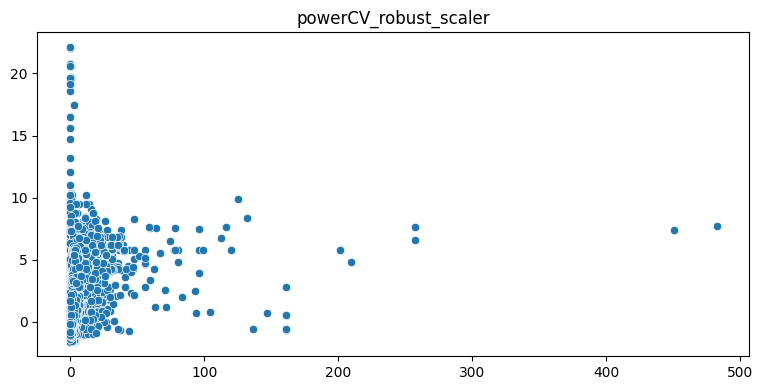

In [6]:
visualizar_outliers_bivariados(df_num,"price_robust_scaler",(15,4))

# Conclusiones
- Eje X: price
- Eje Y: PowerCV

Vemos que hay outlayers

# **Análisis de Outliers Univariados:** 
Una vez identificados, analiza los outliers para determinar si son errores de datos, valores extremos válidos o resultados de condiciones específicas que deben ser tenidos en cuenta. Considera el contexto de cada columna al evaluar la relevancia de estos valores atípicos.

Vamos a usar IQR para el análisis

In [7]:
dictio_iqr = identificar_outliers_iqr(df_num)

La columna PRICE_ROBUST_SCALER tiene 19740 outliers entre el total de 277423 datos, es decir un 7.115487901147345%
La columna POWERCV_ROBUST_SCALER tiene 12954 outliers entre el total de 277423 datos, es decir un 4.669403762485446%


# Análisis de Outliers Multivariados
Ahora es el momento de elegir como vamos a analizarlos, tenemos dos opciones:
- IsolationForest: Detecta los outliers que son muy diferentes/raros del resto
    - Para nuestro lab, nos ayudaría a detectar los outliers de los coches que valían 20 mil millones.
- Local Outlier Factor:
    - Encuentra anomalías en zonas con diferentes densidades, ideal para detectar outliers locales
    - Para outliers que tienen agrupados y dispersos

He decidido usar Local Outlier Factor, al ser la opción más detallada, ya que queremos calcular precios de coches, es conveniente realizarlo con este método

# Vamos a Hacer Isolation Forest
El caso es probar, pero no creo que sea el correcto a usar

se ha hecho outlier_0.01_powerCV_robust_scaler_isoforest
se ha hecho outlier_0.05_powerCV_robust_scaler_isoforest
se ha hecho outlier_0.1_powerCV_robust_scaler_isoforest
Se devuelve df Modificado


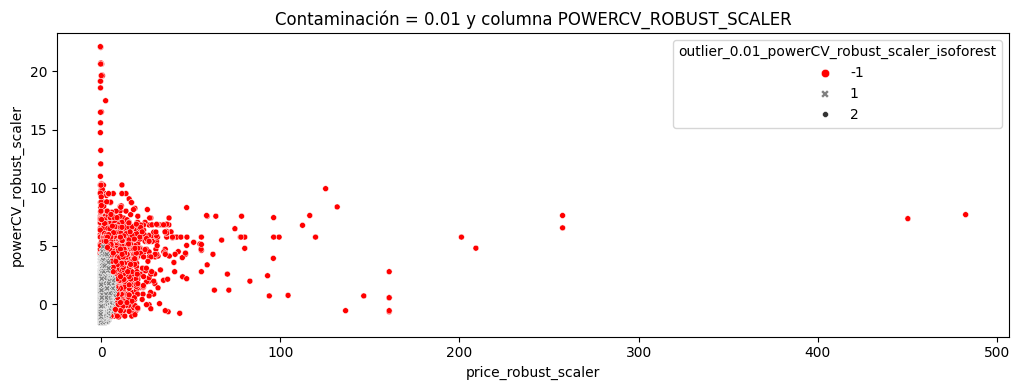

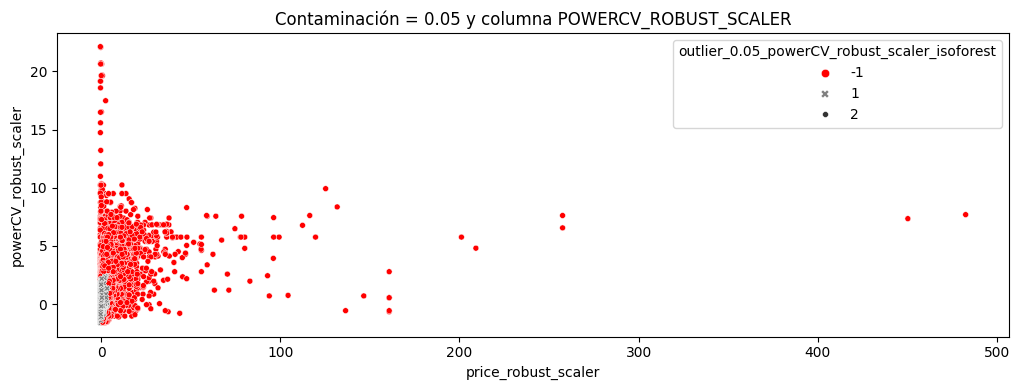

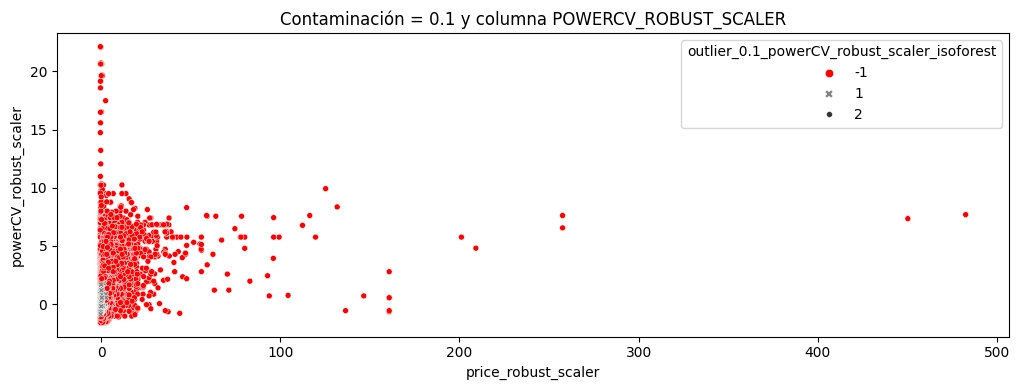

In [8]:
df_test = explorar_outliers_if(df_num,df,"price_robust_scaler",grafica_size=(20,4))

# Realizamos un primer lof con 25, 60 y 80 vecinos
Como análisis inicial

se ha hecho outlier_0.01_powerCV_robust_scaler_lof


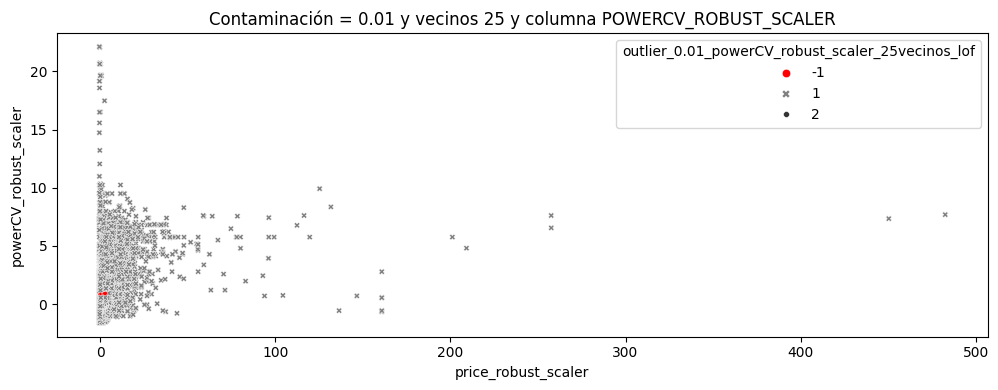

se ha hecho outlier_0.05_powerCV_robust_scaler_lof


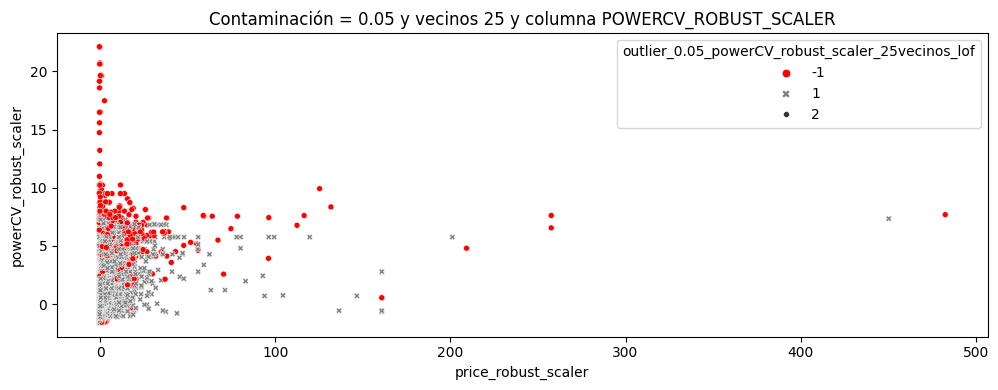

se ha hecho outlier_0.1_powerCV_robust_scaler_lof


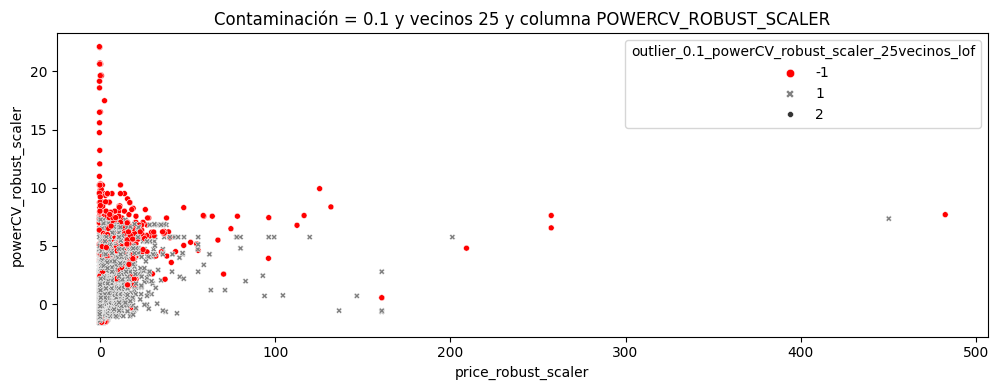

se ha hecho outlier_0.01_powerCV_robust_scaler_lof


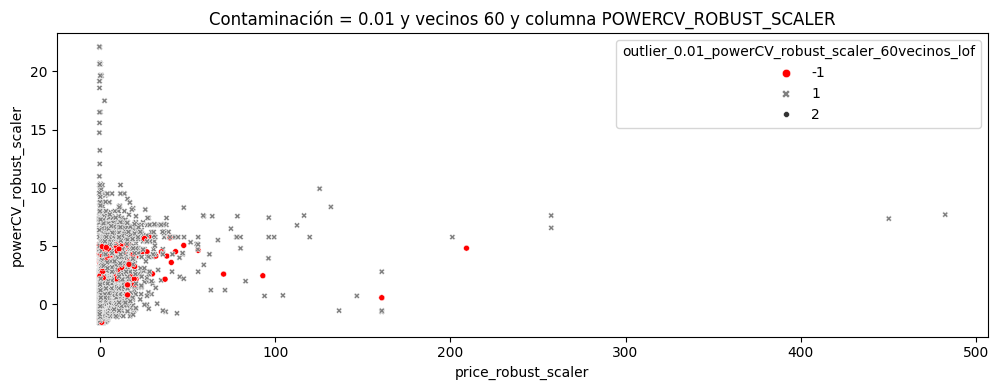

se ha hecho outlier_0.05_powerCV_robust_scaler_lof


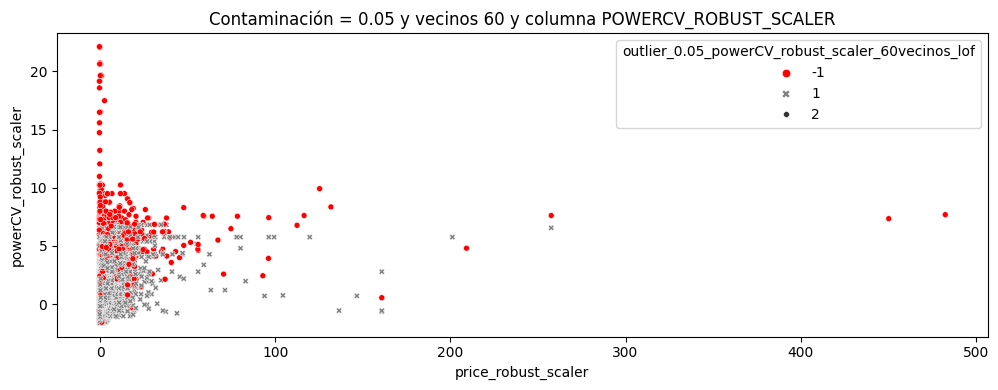

se ha hecho outlier_0.1_powerCV_robust_scaler_lof


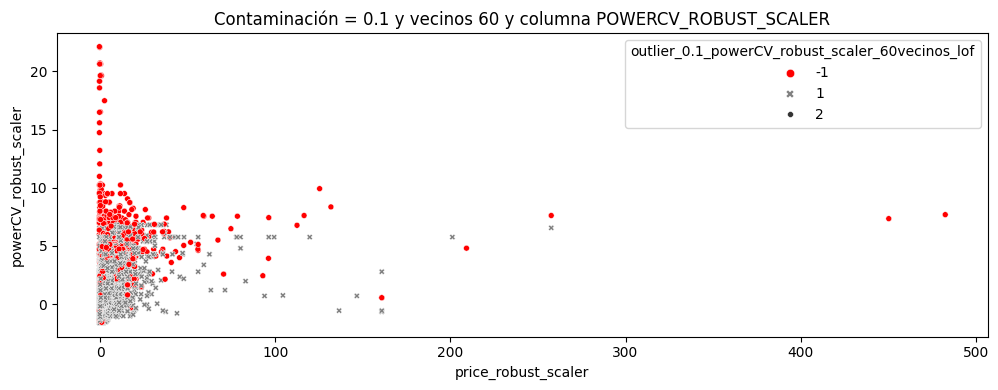

se ha hecho outlier_0.01_powerCV_robust_scaler_lof


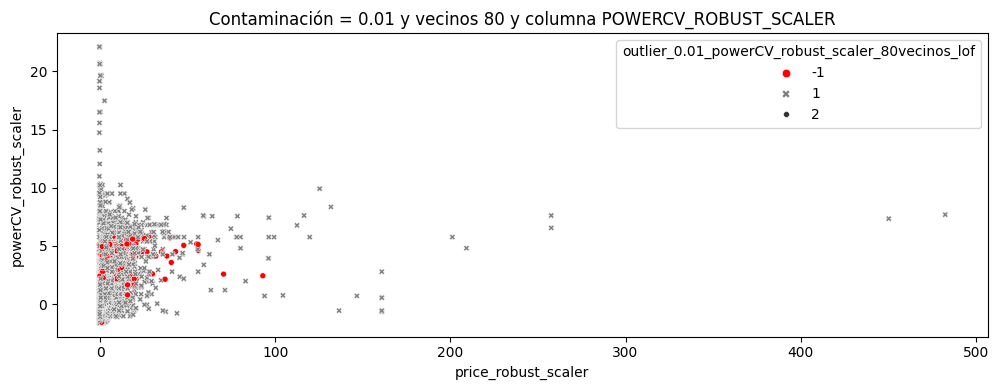

se ha hecho outlier_0.05_powerCV_robust_scaler_lof


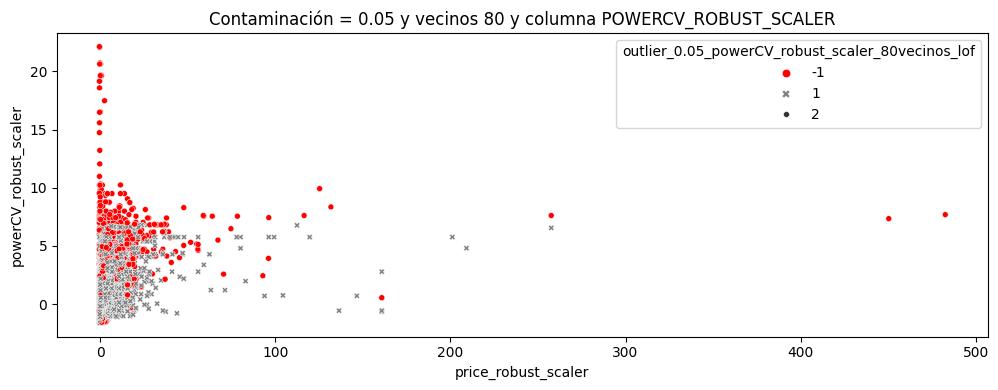

se ha hecho outlier_0.1_powerCV_robust_scaler_lof


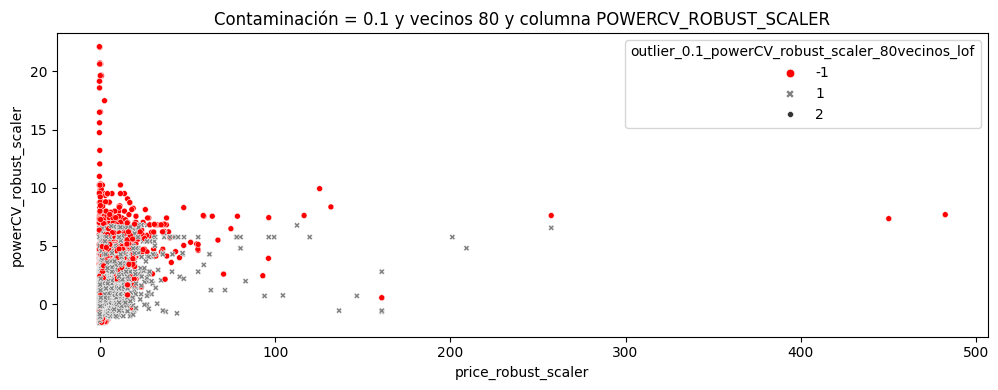

Se devuelve df Modificado


In [9]:
df_lof2 = explorar_outliers_lof(df_num,df,"price_robust_scaler",vecinos=[25,60,80],grafica_size=(20,4))

In [10]:
df_lof2

,seller,offerType,brand,vehicleType,fuelType,gearbox,notRepairedDamage,kilometer,powerCV,price,...,powerCV_robust_scaler,outlier_0.01_powerCV_robust_scaler_25vecinos_lof,outlier_0.05_powerCV_robust_scaler_25vecinos_lof,outlier_0.1_powerCV_robust_scaler_25vecinos_lof,outlier_0.01_powerCV_robust_scaler_60vecinos_lof,outlier_0.05_powerCV_robust_scaler_60vecinos_lof,outlier_0.1_powerCV_robust_scaler_60vecinos_lof,outlier_0.01_powerCV_robust_scaler_80vecinos_lof,outlier_0.05_powerCV_robust_scaler_80vecinos_lof,outlier_0.1_powerCV_robust_scaler_80vecinos_lof
0,private,offer,volkswagen,other,petrol,manually,unknown,150000,81.700794,480.0,...,-0.441924,1,1,1,1,-1,-1,1,-1,-1
1,private,offer,audi,coupe,diesel,manually,yes,125000,187.000000,18300.0,...,1.146318,1,1,1,1,1,1,1,1,1
2,private,offer,jeep,suv,diesel,automatic,unknown,125000,161.000000,9800.0,...,0.754157,1,1,1,1,1,1,1,1,1
3,private,offer,volkswagen,small car,petrol,manually,no,150000,74.000000,1500.0,...,-0.558076,1,1,1,1,1,1,1,1,1
4,private,offer,skoda,small car,diesel,manually,no,90000,68.000000,3600.0,...,-0.648575,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
277418,private,offer,sonstige_autos,other,other,unknown,unknown,20000,108.197668,2200.0,...,-0.042268,1,1,1,1,1,1,1,1,1
277419,private,offer,smart,convertible,petrol,automatic,no,125000,100.000000,1199.0,...,-0.165915,1,1,1,1,1,1,1,1,1
277420,private,offer,volkswagen,bus,diesel,manually,no,150000,101.000000,9200.0,...,-0.150831,1,1,1,1,1,1,1,1,1
277421,private,offer,volkswagen,combi,diesel,manually,unknown,150000,99.000000,3400.0,...,-0.180998,1,1,1,1,1,1,1,1,1


In [11]:
df_lof2.to_csv("../../datos/02_Modelo2/04_autorenew_con_outliers.csv")

# Puedes continuar desde Aquí!

In [12]:
df_lof2 = pd.read_csv("../../datos/02_Modelo2/04_autorenew_con_outliers.csv",index_col=0)

# Los tenemos y ahora?
Vamos a gestionar los outliers, los vamos a clasificar como
- "No es Outlier": Todas las columnas del LOF son 1
- "Improbable Outlier": El 60% de las columnas son 1
- "Es probable que sea Outlier": El 60% de las columnas son -1
- "Outlier Total": El 100% de las columnas son -1

### ¿Porque?
- Queremos saber cuantos hay de cada tipo para poder tomar decisiones

### ¿Qué voy a hacer?
- Voy a contar cuantos 1 tengo en todas las columnas de outliers para poder categorizarla más adelante

In [13]:
df_lof2["tipo_outliers"] = 0

for columna in df_lof2.filter(like="outlier").columns:
    df_lof2["tipo_outliers"] += (df_lof2[columna] == -1).astype(int)


In [14]:
df_lof2.sample()

,seller,offerType,brand,vehicleType,fuelType,gearbox,notRepairedDamage,kilometer,powerCV,price,...,outlier_0.01_powerCV_robust_scaler_25vecinos_lof,outlier_0.05_powerCV_robust_scaler_25vecinos_lof,outlier_0.1_powerCV_robust_scaler_25vecinos_lof,outlier_0.01_powerCV_robust_scaler_60vecinos_lof,outlier_0.05_powerCV_robust_scaler_60vecinos_lof,outlier_0.1_powerCV_robust_scaler_60vecinos_lof,outlier_0.01_powerCV_robust_scaler_80vecinos_lof,outlier_0.05_powerCV_robust_scaler_80vecinos_lof,outlier_0.1_powerCV_robust_scaler_80vecinos_lof,tipo_outliers
249776,private,offer,chrysler,other,lpg,automatic,no,150000,335.0,13800.0,...,1,1,1,1,1,1,1,1,1,0


In [15]:
condiciones = [
    df_lof2["tipo_outliers"] == 0,
    df_lof2["tipo_outliers"].between(1, 4),
    df_lof2["tipo_outliers"].between(5, 8),
    df_lof2["tipo_outliers"] == 9
]

textos = [
    "No es Outlier",
    "Improbable Outlier",
    "Probable Outlier",
    "Total Outlier"
]

df_lof2["tipo_outliers"] = np.select(condiciones, textos, default="Unknown")


In [16]:
df_lof2["tipo_outliers"].unique(
)

array(['Improbable Outlier', 'No es Outlier', 'Probable Outlier',
       'Total Outlier'], dtype=object)

# Elimar columnas
Nos dropeamos las columnas con 1 y -1 para limpieza de la tabla

In [17]:
df_lof2.drop(columns=df_lof2.filter(like="outlier_").columns,inplace=True)

# Ver Tipo Outliers

Así nos podemos hacer una idea de que tenemos

In [18]:
df_lof2["tipo_outliers"].value_counts().reset_index()

,tipo_outliers,count
0,No es Outlier,262534
1,Improbable Outlier,8924
2,Probable Outlier,5933
3,Total Outlier,32


In [19]:
df_lof2[df_lof2["tipo_outliers"] == "Total Outlier"].head()

,seller,offerType,brand,vehicleType,fuelType,gearbox,notRepairedDamage,kilometer,powerCV,price,yearOfRegistration,price_robust_scaler,powerCV_robust_scaler,tipo_outliers
14367,private,offer,volkswagen,other,diesel,manually,no,90000,136.598993,7700.0,The 2000,0.733871,0.386113,Total Outlier
18307,private,offer,volkswagen,coupe,petrol,manually,no,150000,136.598993,7700.0,The 2000,0.733871,0.386113,Total Outlier
23029,private,offer,sonstige_autos,small car,petrol,unknown,yes,30000,48.000000,800.0,The 90's,-0.379032,-0.950238,Total Outlier
28943,private,offer,peugeot,small car,petrol,unknown,no,5000,60.211924,195.0,The 2000,-0.476613,-0.766043,Total Outlier
33903,private,offer,opel,small car,petrol,manually,unknown,30000,136.598993,7700.0,The 2010,0.733871,0.386113,Total Outlier


# Los elimino

Al suponer una muestra tan pequeña y ser confirmados como outliers totales, tenerlos carece de sentido y no daña nuestro análisis

In [20]:
df_lof2 = df_lof2[df_lof2["tipo_outliers"] != "Total Outlier"]
df_lof2["tipo_outliers"].unique()

array(['Improbable Outlier', 'No es Outlier', 'Probable Outlier'],
      dtype=object)

# ¿ Y con el resto?
Vamos a nulificar los CV de todos los que sean improbable o Probable outlier

In [21]:
df_lof2.loc[df_lof2["tipo_outliers"] == "Improbable Outlier", "powerCV"] = np.nan
df_lof2.loc[df_lof2["tipo_outliers"] == "Probable Outlier", "powerCV"] = np.nan
df_lof2.loc[df_lof2["tipo_outliers"] == "Improbable Outlier", "powerCV_robust_scaler"] = np.nan
df_lof2.loc[df_lof2["tipo_outliers"] == "Probable Outlier", "powerCV_robust_scaler"] = np.nan

In [22]:
df_lof2["powerCV_robust_scaler"].isnull().sum()

np.int64(14857)

# Reseteamos Index

In [23]:
df_lof2.reset_index(inplace=True,drop=True)

# Los Imputamos
Ahora imputaremos con KNN Imputer

In [24]:
df = df_lof2.copy()

In [25]:
df.isnull().sum()

seller                       0
offerType                    0
brand                        0
vehicleType                  0
fuelType                     0
gearbox                      0
notRepairedDamage            0
kilometer                    0
powerCV                  14857
price                        0
yearOfRegistration           0
price_robust_scaler          0
powerCV_robust_scaler    14857
tipo_outliers                0
dtype: int64

# Rellenamos con Random Forest

In [27]:
df_num = df.select_dtypes(include=np.number)

# Random Forest
iterative_imputer = IterativeImputer(
    estimator=RandomForestRegressor(random_state=42),
    #max_iter=10,  # Número de iteraciones para ajustar los valores
    random_state=42
)

df_num_imputado = iterative_imputer.fit_transform(df_num)
df_num_sin_nulos = pd.DataFrame(df_num_imputado, columns=df_num.columns)
df_rf = df.copy()
df_rf[df_num.columns] = df_num_sin_nulos
df_rf.isnull().sum()


seller                   0
offerType                0
brand                    0
vehicleType              0
fuelType                 0
gearbox                  0
notRepairedDamage        0
kilometer                0
powerCV                  0
price                    0
yearOfRegistration       0
price_robust_scaler      0
powerCV_robust_scaler    0
tipo_outliers            0
dtype: int64

In [29]:
df_rf.reset_index(drop=True,inplace=True)
df_rf.to_csv("../../datos/02_Modelo2/05_autorenew_outliers_gestionados.csv")